<h2> Maritime Risk: Piracy </h2>

<h3> Data Cleaning </h3>
Source: Kaggle - Global Maritime Pirate Attacks (1993–2020)

https://www.kaggle.com/datasets/n0n5ense/global-maritime-pirate-attacks-19932020 

In [316]:
import pandas as pd
import numpy as np

# Paths
PIRATE_PATH     = "piracy/raw_data_archive/pirate_attacks.csv"
CODES_PATH      = "piracy/raw_data_archive/country_codes.csv"          # for region lookup
INDICATORS_PATH = "piracy/raw_data_archive/country_indicators.csv"     # optional

OUT_PATH        = "piracy/cleaned_data_output/cleaned_pirate_attacks.csv"
MIN_ROWS        = 5000  # keep at least this many rows after cleaning

pd.set_option("display.max_columns", 100)


In [317]:
# Load CSVs
pir = pd.read_csv(PIRATE_PATH)
codes = pd.read_csv(CODES_PATH)

# Normalize headers once
pir.columns = [c.strip().lower().replace(" ", "_") for c in pir.columns]
codes.columns = [c.strip().lower().replace(" ", "_") for c in codes.columns]

pir.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7511 entries, 0 to 7510
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  7511 non-null   object 
 1   time                  1149 non-null   object 
 2   longitude             7511 non-null   float64
 3   latitude              7511 non-null   float64
 4   attack_type           7391 non-null   object 
 5   location_description  7503 non-null   object 
 6   nearest_country       7492 non-null   object 
 7   eez_country           7216 non-null   object 
 8   shore_distance        7511 non-null   float64
 9   shore_longitude       7511 non-null   float64
 10  shore_latitude        7511 non-null   float64
 11  attack_description    1173 non-null   object 
 12  vessel_name           6079 non-null   object 
 13  vessel_type           1173 non-null   object 
 14  vessel_status         6599 non-null   object 
 15  data_source          

In [318]:
pir.head(7)

,date,time,longitude,latitude,attack_type,location_description,nearest_country,eez_country,shore_distance,shore_longitude,shore_latitude,attack_description,vessel_name,vessel_type,vessel_status,data_source
0,1993-01-02,NaN,116.9667,19.700000,NaN,Hong Kong - Luzon - Hainan,CHN,TWN,357.502373,115.825956,22.746644,NaN,Mv Cosmic Leader,NaN,NaN,mappingpiracy
1,1993-01-04,NaN,116.0000,22.350000,NaN,Hong Kong - Luzon - Hainan,CHN,CHN,47.431573,115.825956,22.746644,NaN,Mv Tricolor Star III,NaN,NaN,mappingpiracy
2,1993-01-06,NaN,115.2500,19.670000,NaN,Hong Kong - Luzon - Hainan,CHN,TWN,280.811871,114.302501,22.044867,NaN,Mv Arktis Star,NaN,NaN,mappingpiracy
3,1993-01-08,NaN,124.5833,29.900000,NaN,East China Sea,CHN,CHN,209.923396,122.409679,29.911200,NaN,Ussurijsk,NaN,NaN,mappingpiracy
4,1993-01-12,NaN,120.2667,18.133333,NaN,Hong Kong - Luzon - Hainan,PHL,PHL,22.027332,120.470063,18.091010,NaN,Mv Chennai Nermai,NaN,NaN,mappingpiracy
5,1993-01-13,NaN,101.8500,9.717300,NaN,Gulf of Thailand. South China Sea,KHM,KHM,184.796641,103.292166,10.583157,NaN,Emelyan Yaroslavskiy,NaN,NaN,mappingpiracy
6,1993-01-25,NaN,106.8667,8.566667,NaN,South China Sea,VNM,VNM,27.437344,106.655772,8.698879,NaN,Mv Indira Ghandhi,NaN,NaN,mappingpiracy


#### Handle Missing Values

In [319]:
print("Missing values:\n", pir.isna().sum().sort_values(ascending=False).head(12))
print("\nDtypes:\n", pir.dtypes)

Missing values:
 time                    6362
attack_description      6338
vessel_type             6338
vessel_name             1432
vessel_status            912
eez_country              295
attack_type              120
nearest_country           19
location_description       8
longitude                  0
latitude                   0
date                       0
dtype: int64

Dtypes:
 date                     object
time                     object
longitude               float64
latitude                float64
attack_type              object
location_description     object
nearest_country          object
eez_country              object
shore_distance          float64
shore_longitude         float64
shore_latitude          float64
attack_description       object
vessel_name              object
vessel_type              object
vessel_status            object
data_source              object
dtype: object


In [320]:
# Drop exact duplicates
pir = pir.drop_duplicates()

# drop columns with > 80% missing values, irrelevant columns
pir = pir.drop(['time','attack_description','vessel_type','vessel_name'], axis=1)

pir['vessel_status'] = pir['vessel_status'].fillna('Unknown')
pir['attack_type'] = pir['attack_type'].fillna('Unknown')

In [321]:
# Check if missing nearest_country can be filled from eez_country
missing_nearest = pir['nearest_country'].isna()
print(f"\nOf {missing_nearest.sum()} missing nearest_country:")
print(f"Have eez_country: {pir.loc[missing_nearest, 'eez_country'].notna().sum()}")

# Fill missing nearest_country from eez_country where possible
mask = pir['nearest_country'].isna() & pir['eez_country'].notna()
pir.loc[mask, 'nearest_country'] = pir.loc[mask, 'eez_country']
print('total number of missing nearest_country', pir['nearest_country'].isna().sum())

# Fill remaining nearest_country as "Unknown"
pir['nearest_country'] = pir['nearest_country'].fillna('Unknown')

# EEZ country - fill with "International Waters"
pir['eez_country'] = pir['eez_country'].fillna('International Waters')

# keep missing location_desccriptions as unknown as it is not critical

print("Missing values:\n", pir.isna().sum().sort_values(ascending=False).head(12))
print("\nDtypes:\n", pir.dtypes)


Of 19 missing nearest_country:
Have eez_country: 1
total number of missing nearest_country 18
Missing values:
 location_description    8
date                    0
latitude                0
longitude               0
attack_type             0
nearest_country         0
eez_country             0
shore_distance          0
shore_longitude         0
shore_latitude          0
vessel_status           0
data_source             0
dtype: int64

Dtypes:
 date                     object
longitude               float64
latitude                float64
attack_type              object
location_description     object
nearest_country          object
eez_country              object
shore_distance          float64
shore_longitude         float64
shore_latitude          float64
vessel_status            object
data_source              object
dtype: object


#### Data Type Conversion

In [322]:
# Type Conversions
# Date
pir["date"] = pd.to_datetime(pir["date"], errors="coerce")

# type conversions check
print(pir[["date"]].head(10))
print("date dtype:", pir["date"].dtype)

# denoising
# Year & month
pir["year"] = pir["date"].dt.year
pir["month"] = pir["date"].dt.month


        date
0 1993-01-02
1 1993-01-04
2 1993-01-06
3 1993-01-08
4 1993-01-12
5 1993-01-13
6 1993-01-25
7 1993-01-26
8 1993-01-26
9 1993-01-26
date dtype: datetime64[ns]


#### Data standardisation for attack type

In [323]:
pir['attack_type'].value_counts()

attack_type_mapping = {
    'Boarding': 'Boarded', 
}

pir['attack_type'] = pir['attack_type'].replace(attack_type_mapping)

print("After standardization:")
print(pir['attack_type'].value_counts())

After standardization:
attack_type
Boarded       4782
Attempted     1994
Hijacked       502
Unknown        120
Fired Upon      73
Suspicious      16
Explosion        3
Detained         1
Name: count, dtype: int64


#### Combining country and region info into one dataframe

In [324]:
# join region info from country_codes.csv
codes["country"] = codes["country"].astype(str).str.upper().str.strip()
codes = codes.drop_duplicates(subset=["country"])

pir = pir.merge(
    codes[["country", "region", "country_name"]],  # Include country_name
    left_on="nearest_country", right_on="country", how="left"
).drop(columns=["country"]).rename(columns={
    "region": "nearest_region",
    "country_name": "nearest_country_full"  # Add full country name
})


In [325]:
# Minimum row guard (keeps project scale)
assert len(pir) >= MIN_ROWS, f"Only {len(pir)} rows remain (<{MIN_ROWS}). Loosen filters and re-run."

# Quick QA
print("Rows:", len(pir))
print("\nLongitude range:", pir["longitude"].min(), pir["longitude"].max())
print("Latitude range:", pir["latitude"].min(), pir["latitude"].max())
print("\nMissing (top 10):\n", pir.isna().sum().sort_values(ascending=False).head(10))

# Save
pir.to_csv(OUT_PATH, index=False)
print(f"\n✅ Saved cleaned file → {OUT_PATH}")


Rows: 7491

Longitude range: -163.9928 160.2646
Latitude range: -34.9033333 56.5878

Missing (top 10):
 nearest_country_full    35
nearest_region          35
location_description     8
date                     0
attack_type              0
nearest_country          0
latitude                 0
longitude                0
shore_distance           0
eez_country              0
dtype: int64

✅ Saved cleaned file → piracy/cleaned_data_output/cleaned_pirate_attacks.csv


### EDA

In [326]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("piracy/cleaned_data_output/cleaned_pirate_attacks.csv")

In [327]:
df.head()

,date,longitude,latitude,attack_type,location_description,nearest_country,eez_country,shore_distance,shore_longitude,shore_latitude,vessel_status,data_source,year,month,nearest_region,nearest_country_full
0,1993-01-02,116.9667,19.700000,Unknown,Hong Kong - Luzon - Hainan,CHN,TWN,357.502373,115.825956,22.746644,Unknown,mappingpiracy,1993,1,East Asia & Pacific,China
1,1993-01-04,116.0000,22.350000,Unknown,Hong Kong - Luzon - Hainan,CHN,CHN,47.431573,115.825956,22.746644,Unknown,mappingpiracy,1993,1,East Asia & Pacific,China
2,1993-01-06,115.2500,19.670000,Unknown,Hong Kong - Luzon - Hainan,CHN,TWN,280.811871,114.302501,22.044867,Unknown,mappingpiracy,1993,1,East Asia & Pacific,China
3,1993-01-08,124.5833,29.900000,Unknown,East China Sea,CHN,CHN,209.923396,122.409679,29.911200,Unknown,mappingpiracy,1993,1,East Asia & Pacific,China
4,1993-01-12,120.2667,18.133333,Unknown,Hong Kong - Luzon - Hainan,PHL,PHL,22.027332,120.470063,18.091010,Unknown,mappingpiracy,1993,1,East Asia & Pacific,Philippines


In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7491 entries, 0 to 7490
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  7491 non-null   object 
 1   longitude             7491 non-null   float64
 2   latitude              7491 non-null   float64
 3   attack_type           7491 non-null   object 
 4   location_description  7483 non-null   object 
 5   nearest_country       7491 non-null   object 
 6   eez_country           7491 non-null   object 
 7   shore_distance        7491 non-null   float64
 8   shore_longitude       7491 non-null   float64
 9   shore_latitude        7491 non-null   float64
 10  vessel_status         7491 non-null   object 
 11  data_source           7491 non-null   object 
 12  year                  7491 non-null   int64  
 13  month                 7491 non-null   int64  
 14  nearest_region        7456 non-null   object 
 15  nearest_country_full 

In [329]:
df.describe(include='all')

,date,longitude,latitude,attack_type,location_description,nearest_country,eez_country,shore_distance,shore_longitude,shore_latitude,vessel_status,data_source,year,month,nearest_region,nearest_country_full
count,7491,7491.000000,7491.000000,7491,7483,7491,7491,7491.000000,7491.000000,7491.000000,7491,7491,7491.000000,7491.000000,7456,7456
unique,4887,NaN,NaN,8,3986,104,103,NaN,NaN,NaN,13,2,NaN,NaN,7,97
top,2009-01-01,NaN,NaN,Boarded,Gulf of Aden,IDN,IDN,NaN,NaN,NaN,Anchored,mappingpiracy,NaN,NaN,East Asia & Pacific,Indonesia
freq,7,NaN,NaN,4782,328,1938,1980,NaN,NaN,NaN,3255,6318,NaN,NaN,3208,1938
mean,NaN,59.266160,6.498860,NaN,NaN,NaN,NaN,53.768474,59.212355,6.592348,NaN,NaN,2006.678014,6.410626,NaN,NaN
std,NaN,58.551331,10.538270,NaN,NaN,NaN,NaN,126.739603,58.567407,10.616323,NaN,NaN,6.965808,3.417049,NaN,NaN
min,NaN,-163.992800,-34.903333,NaN,NaN,NaN,NaN,0.039189,-169.512766,-34.898696,NaN,NaN,1993.000000,1.000000,NaN,NaN
25%,NaN,10.029917,0.825000,NaN,NaN,NaN,NaN,2.922736,9.833832,0.893744,NaN,NaN,2001.000000,4.000000,NaN,NaN
50%,NaN,83.400000,5.010000,NaN,NaN,NaN,NaN,10.081557,83.299083,5.235541,NaN,NaN,2007.000000,6.000000,NaN,NaN
75%,NaN,105.166700,13.148350,NaN,NaN,NaN,NaN,36.219880,105.202159,13.585598,NaN,NaN,2012.000000,10.000000,NaN,NaN


#### 1. Temporal Analysis

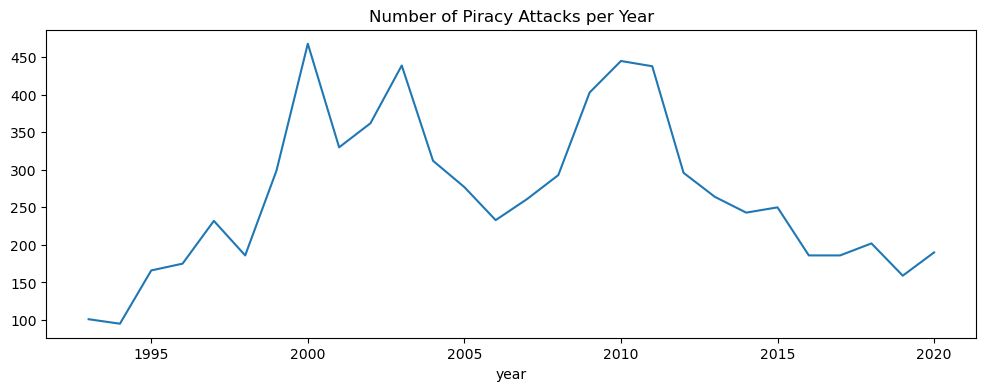

C:\Users\user\AppData\Local\Temp\ipykernel_21148\632922922.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="month", data=df, palette="Blues")


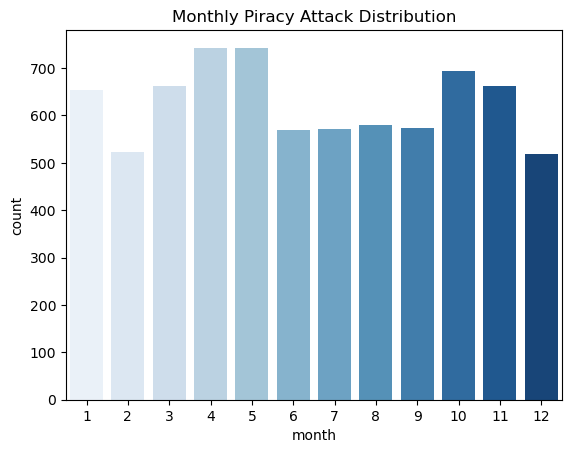

In [330]:
# Attacks per year
attacks_per_year = df.groupby("year").size()
attacks_per_year.plot(kind="line", figsize=(12,4), title="Number of Piracy Attacks per Year")
plt.show()

# Attacks by month (seasonality)
sns.countplot(x="month", data=df, palette="Blues")
plt.title("Monthly Piracy Attack Distribution")
plt.show()

**Temporal Insights:** Piracy peaked in the early 2000s and 2010s but declined sharply after 2012 possibly due to international interventions. Unlike weather-dependent crimes, piracy shows minimal seasonal variation, occurring consistently year-round as seen in the relatively even distribution accross months.

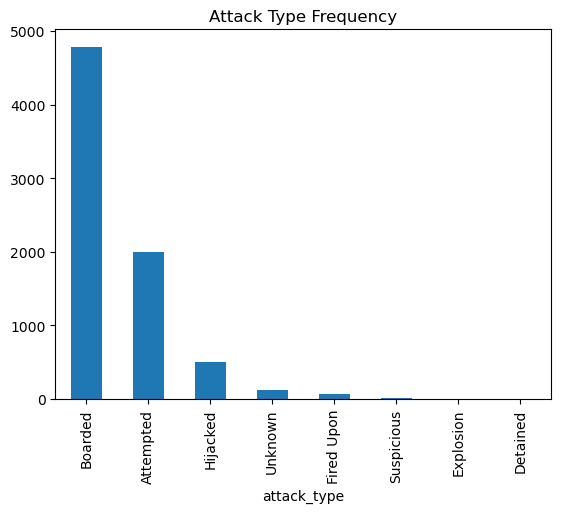

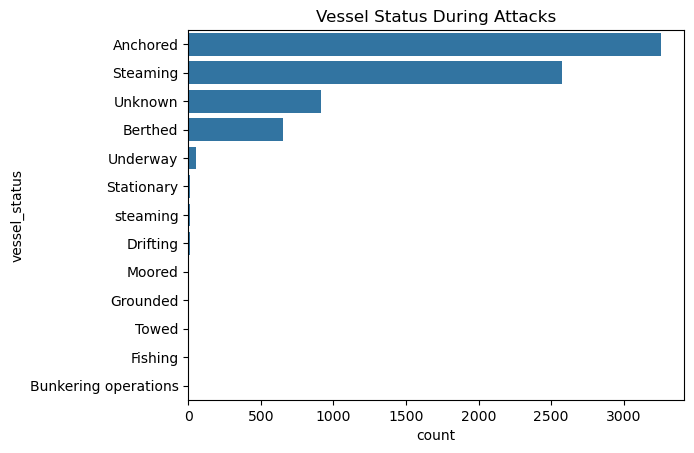

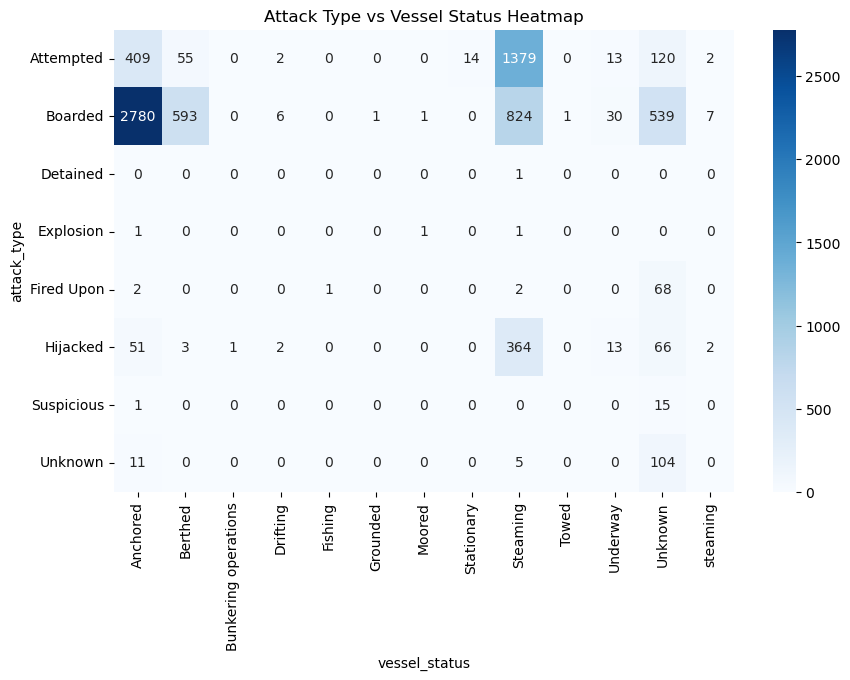

In [331]:
# Attack type distribution
pir["attack_type"].value_counts().plot(kind="bar")
plt.title("Attack Type Frequency")
plt.show()

# Vessel status distribution
sns.countplot(y="vessel_status", data=pir, order=pir["vessel_status"].value_counts().index)
plt.title("Vessel Status During Attacks")
plt.show()

# # Heatmap
crosstab_no_margins = pd.crosstab(df['attack_type'], df['vessel_status'])
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_no_margins, annot=True, fmt='d', cmap='Blues')
plt.title("Attack Type vs Vessel Status Heatmap")
plt.show()

Maritime piracy operations exhibit clear tactical preferences with **anchored** vessels targeted for **boarding** attacks representing the primary threat pattern, followed by attempted steaming vessels. This suggests pirates prioritise operational success over targets of opportunity, requiring targeted security measures during high-risk vessel statuses.

#### 3. Geospatial Distribution Analysis

In [332]:
# !pip install geopandas
!pip install geodatasets

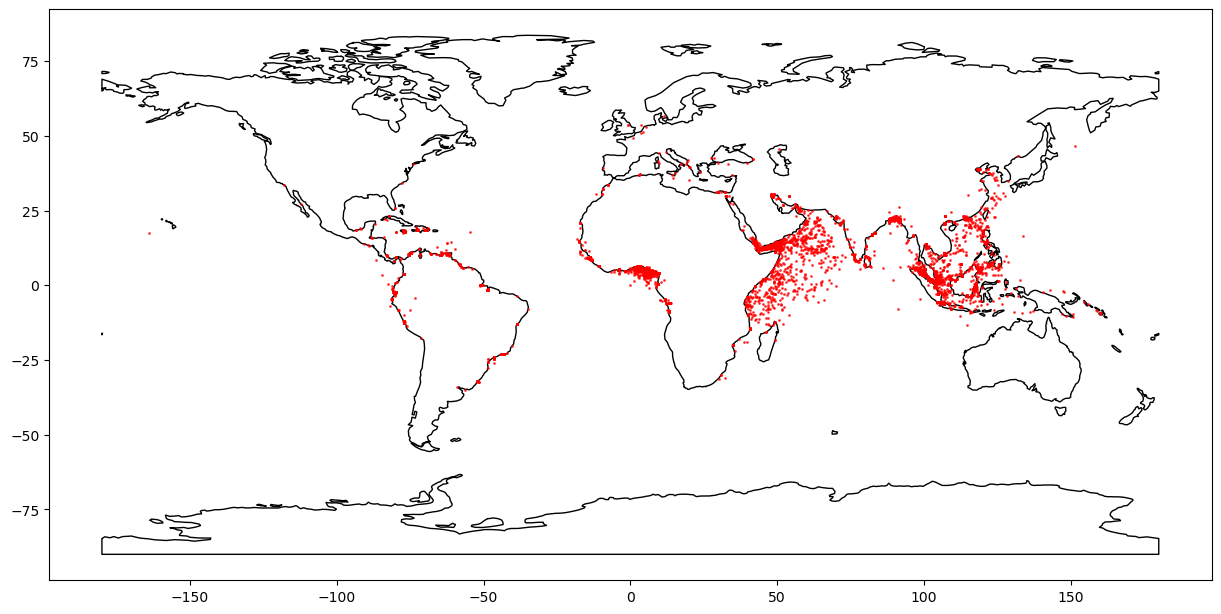

In [333]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from geodatasets import get_path

# # Geographic distribution of piracy attacks worldwide
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

world = geopandas.read_file(get_path("naturalearth.land"))

ax = world.plot(color="white", edgecolor="black", figsize=(15, 10))

gdf.plot(ax=ax, color="red", markersize=1, alpha=0.7)

plt.show()

Number of outliers: 1132
Total observations: 7491
Percentage of outliers: 15.11%
Outlier bounds: [-47.02, 86.17]


<Axes: xlabel='shore_distance'>

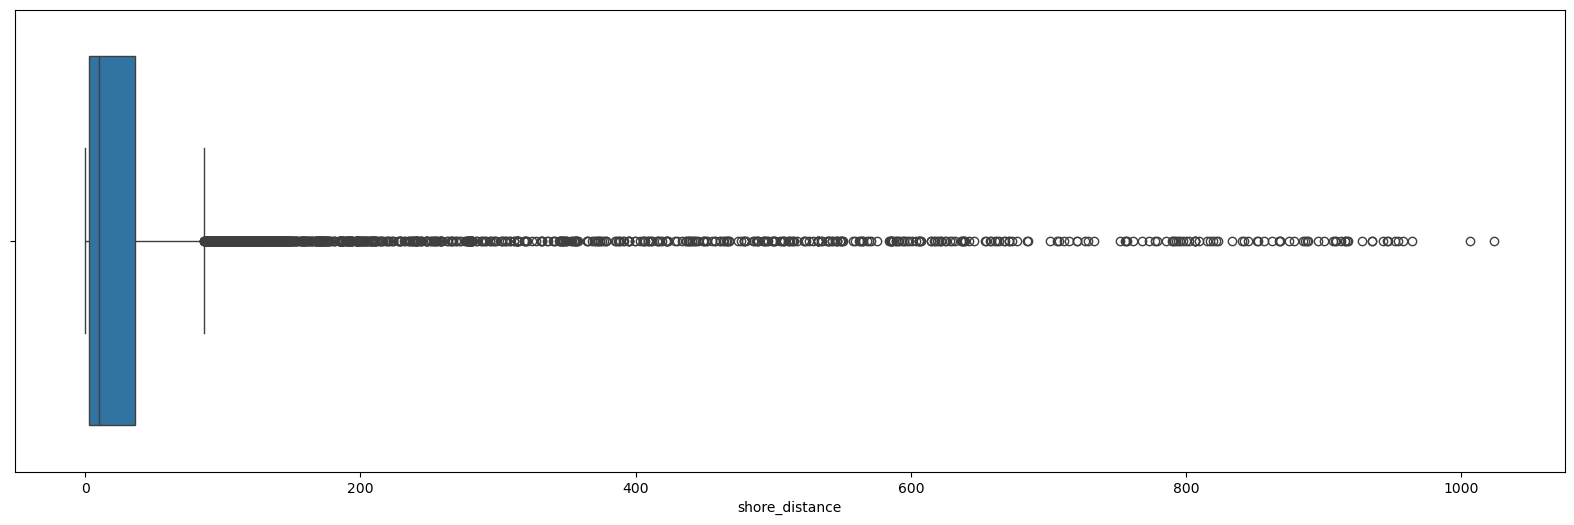

In [334]:
import seaborn as sns

# Calculate outliers using IQR method
Q1 = df['shore_distance'].quantile(0.25)
Q3 = df['shore_distance'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['shore_distance'] < lower_bound) | (df['shore_distance'] > upper_bound)]
num_outliers = len(outliers)

print(f"Number of outliers: {num_outliers}")
print(f"Total observations: {len(df)}")
print(f"Percentage of outliers: {num_outliers/len(df)*100:.2f}%")
print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

plt.figure(figsize=(20, 6))
sns.boxplot(x=df['shore_distance'])

Piracy attacks are concentrated in a few high-risk regions (Somalia, Gulf of Guinea, SE Asia). These are strongly associated with busy shipping lanes and coastal proximity. Thus, this suggests that predictive models should incorporate geographic clustering (e.g., region-based risk scoring, distance to chokepoints) rather than treating piracy as a uniform global threat. The boxplots also shows that there is a high outlier percentage (15.11%) which could suggest that there are 2 distinct attack pattern (costal attacks and deep-water attacks).

#### 

C:\Users\user\AppData\Local\Temp\ipykernel_21148\2628972031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="mako")


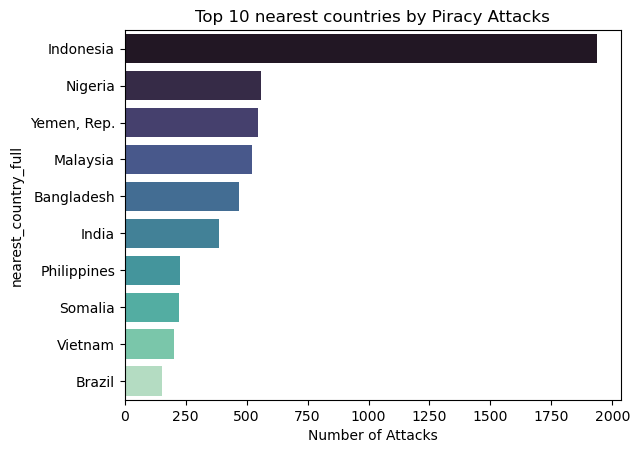

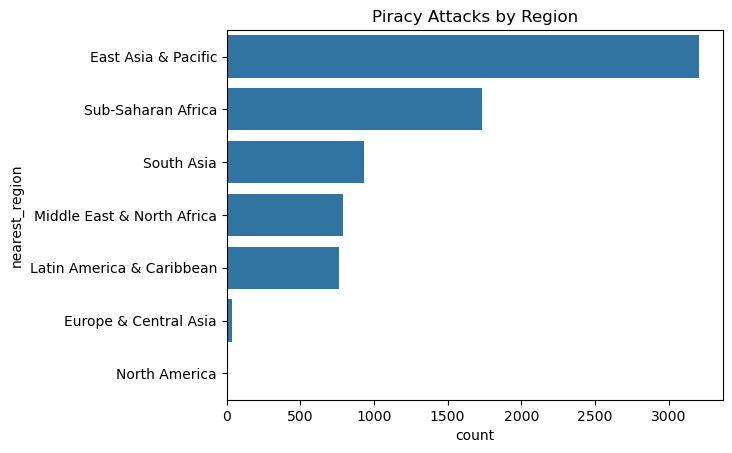

In [335]:
# Top 10 nearest countries
top_countries = pir["nearest_country_full"].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="mako")
plt.title("Top 10 nearest countries by Piracy Attacks")
plt.xlabel("Number of Attacks")
plt.show()

# Region distribution
sns.countplot(y="nearest_region", data=pir, order=pir["nearest_region"].value_counts().index)
plt.title("Piracy Attacks by Region")
plt.show()

Piracy is not evenly spread worldwide but geographically clustered. Strait of Malacca & Indonesian waters has highest risk globally, followed by Gulf of Guinea (Nigeria) which has a persistent hotspot. Regions with strong naval presence (Europe, North America) report almost no incidents, suggesting the impact of maritime security enforcement.

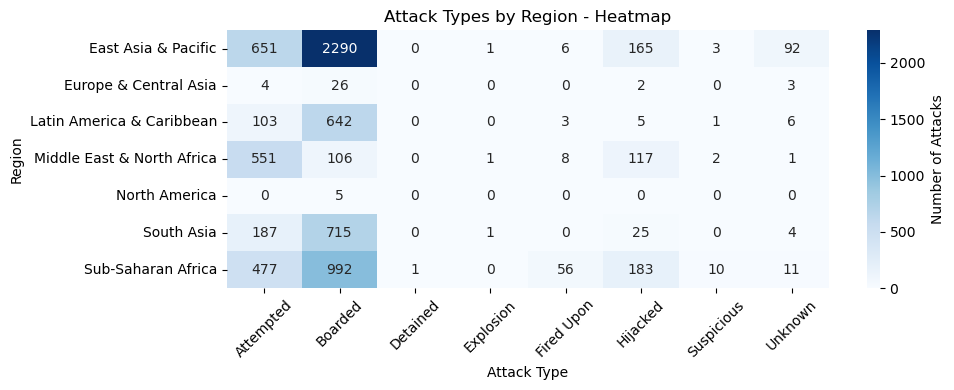

In [336]:
# Attack type by region - Heatmap
plt.figure(figsize=(10,4))
region_attack_crosstab = pd.crosstab(pir['nearest_region'], pir['attack_type'])
sns.heatmap(region_attack_crosstab, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Attacks'})
plt.title("Attack Types by Region - Heatmap")
plt.xlabel("Attack Type")
plt.ylabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The heatmap shows that piracy attacks are regionally distinct in both frequency and severity. East Asia & Pacific records the highest number of incidents, dominated by successful boardings, indicating opportunistic attacks in busy shipping lanes. Sub-Saharan Africa has fewer attacks overall but shows higher violence, with more hijackings and vessels fired upon, consistent with Gulf of Guinea piracy. In contrast, Europe and North America show negligible activity due to strong maritime enforcement.

### Pre-Processing and Preliminary Results
#### Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filter out rare classes (< 5 samples)
min_samples = 5
valid_classes = class_counts[class_counts >= min_samples].index
print(f"\nKeeping classes with >= {min_samples} samples:")
print(valid_classes.tolist())

# Filter dataset
mask = df['attack_type'].isin(valid_classes)
df_filtered = df[mask].copy()

# One-hot encode categorical variables (EXCLUDE attack_type - our target)
categorical_cols = ["vessel_status", "nearest_region"] 
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True)

# Frequency encoding for countries
country_freq = df_filtered['nearest_country_full'].value_counts().to_dict()
df_encoded['country_risk_score'] = df_filtered['nearest_country_full'].map(country_freq)

# Select features (X) and target (y)
feature_columns = [col for col in df_encoded.columns if col not in [
    'nearest_country_full', 'eez_country', 'shore_cat', 'attack_type','date','location_description', 'nearest_country','data_source'
]]

X = df_encoded[feature_columns]  # Features (predictors)
y = df_encoded['attack_type']    # Target (what we want to predict)

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Feature columns: {X.columns.tolist()}")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['longitude', 'latitude','shore_latitude','shore_longitude', 'shore_distance', 'year', 'month', 'country_risk_score']
# Only scale columns that exist in X
existing_numerical = [col for col in numerical_cols if col in X.columns]
if existing_numerical:
    X[existing_numerical] = scaler.fit_transform(X[existing_numerical])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target classes: {y.unique()}")


Keeping classes with >= 5 samples:
['Boarded', 'Attempted', 'Hijacked', 'Unknown', 'Fired Upon', 'Suspicious']

Features (X) shape: (7487, 26)
Target (y) shape: (7487,)
Feature columns: ['longitude', 'latitude', 'shore_distance', 'shore_longitude', 'shore_latitude', 'year', 'month', 'vessel_status_Berthed', 'vessel_status_Bunkering operations', 'vessel_status_Drifting', 'vessel_status_Fishing', 'vessel_status_Grounded', 'vessel_status_Moored', 'vessel_status_Stationary', 'vessel_status_Steaming', 'vessel_status_Towed', 'vessel_status_Underway', 'vessel_status_Unknown', 'vessel_status_steaming', 'nearest_region_Europe & Central Asia', 'nearest_region_Latin America & Caribbean', 'nearest_region_Middle East & North Africa', 'nearest_region_North America', 'nearest_region_South Asia', 'nearest_region_Sub-Saharan Africa', 'country_risk_score']

Training set: (5989, 26)
Test set: (1498, 26)
Target classes: ['Unknown' 'Attempted' 'Hijacked' 'Boarded' 'Fired Upon' 'Suspicious']


C:\Users\user\AppData\Local\Temp\ipykernel_21148\404017770.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[existing_numerical] = scaler.fit_transform(X[existing_numerical])


We performed several preprocessing steps to prepare the piracy dataset for machine learning classification.  
- **Data cleaning**: Removed rare classes (<5 samples) and standardized categorical values.  
- **Categorical encoding**: Applied one-hot encoding to `vessel_status` and `nearest_region`; frequency encoding was used for `nearest_country` to reduce dimensionality.  
- **Feature engineering**: Extracted `year` and `month` from the attack date, created distance-to-shore categories, and added a country risk score based on historical frequency.  
- **Scaling**: Standardized numerical features (longitude, latitude, shore distance, etc.) to ensure comparability.  
- **Target definition**: The target variable was `attack_type`, representing the type/severity of piracy attack (e.g., Attempted, Boarded, Hijacked).  
- **Train-test split**: Dataset split into 80% training and 20% testing, stratified by attack type to preserve class distribution.

In [351]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Decision Tree Classifier
print("\n1. DECISION TREE CLASSIFIER")
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, min_samples_split=20)
dt_model.fit(X_train, y_train)  # TRAIN the model
dt_predictions = dt_model.predict(X_test)  # TEST the model

# Evaluate Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, dt_predictions, zero_division=0))

# 2. Random Forest Classifier
print("\n2. RANDOM FOREST CLASSIFIER")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)  # TRAIN the model
rf_predictions = rf_model.predict(X_test)  # TEST the model

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, rf_predictions, zero_division=0))

# 3. Compare Models
print("\n=== MODEL COMPARISON ===")
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Accuracy': [dt_accuracy, rf_accuracy]
})
print(comparison)


1. DECISION TREE CLASSIFIER
Decision Tree Accuracy: 0.756

Detailed Classification Report:
              precision    recall  f1-score   support

   Attempted       0.67      0.51      0.58       399
     Boarded       0.78      0.95      0.85       957
  Fired Upon       0.00      0.00      0.00        15
    Hijacked       0.36      0.04      0.07       100
  Suspicious       0.00      0.00      0.00         3
     Unknown       1.00      0.83      0.91        24

    accuracy                           0.76      1498
   macro avg       0.47      0.39      0.40      1498
weighted avg       0.72      0.76      0.72      1498


2. RANDOM FOREST CLASSIFIER
Random Forest Accuracy: 0.771

Detailed Classification Report:
              precision    recall  f1-score   support

   Attempted       0.72      0.52      0.60       399
     Boarded       0.78      0.97      0.86       957
  Fired Upon       0.00      0.00      0.00        15
    Hijacked       0.00      0.00      0.00       100
  

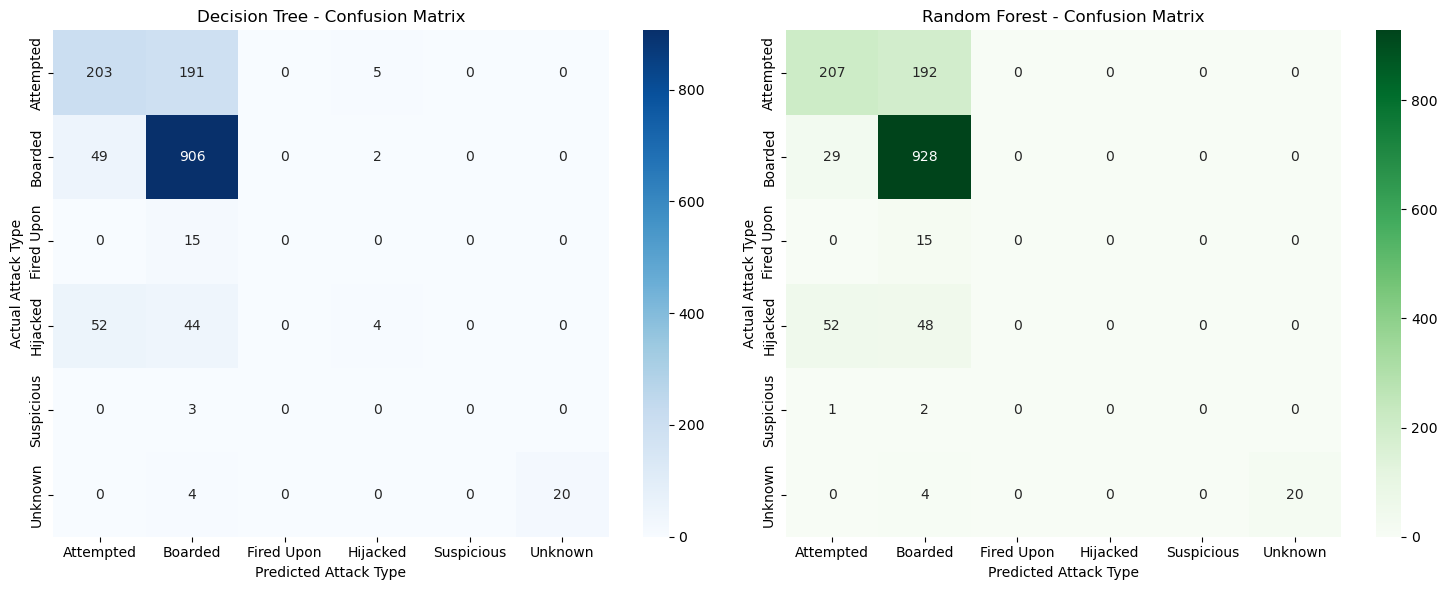

In [356]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Decision Tree Confusion Matrix
dt_cm = confusion_matrix(y_test, dt_predictions)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=dt_model.classes_, 
           yticklabels=dt_model.classes_, ax=axes[0])
axes[0].set_title('Decision Tree - Confusion Matrix')
axes[0].set_xlabel('Predicted Attack Type')
axes[0].set_ylabel('Actual Attack Type')

# Random Forest Confusion Matrix  
rf_cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=rf_model.classes_, 
           yticklabels=rf_model.classes_, ax=axes[1])
axes[1].set_title('Random Forest - Confusion Matrix')
axes[1].set_xlabel('Predicted Attack Type')
axes[1].set_ylabel('Actual Attack Type')

plt.tight_layout()
plt.show()

Both the Decision Tree and Random Forest models achieved moderate accuracy (76–77%), showing that piracy attack types can be predicted using vessel status, region, and location-based features. Both models perform very well on the dominant “Boarded” class (recall above 0.95 for Random Forest), but struggle significantly with rare classes such as “Hijacked,” “Fired Upon,” and “Suspicious,” which are frequently misclassified as “Boarded” or “Attempted.”

The Decision Tree provides slightly more balanced recognition of minority classes but with lower precision overall, while the Random Forest improves overall accuracy and stability at the cost of completely overlooking some rare categories. 

These results highlight a strong class imbalance problem where rare events are poorly detected. We will need to address imbalance (eg. class weighting, or alternative evaluation metrics) to improve detection of critical but less frequent piracy events.